# Make predictions using the optimal boundary conditions

In [11]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py
from glob import glob

import pymc3 as pm

from theano import shared
from theano import tensor as tt

from soda.utils.othertime import SecondsSince

In [2]:
%matplotlib notebook

In [3]:
h5path = r'C:\Users\mrayson\cloudstor\Data\KdV\vkdv_optimization\*.h5'
h5files = sorted(glob(h5path))
nsteps = len(h5files)
nsteps

325

In [4]:
# Read in one file to get the array sizes
with h5py.File(h5files[0], "r") as f:
    frq = f['frq'][:] 
    density_params = f['density_params'][:] 
    time_obs = f['time_obs'][:]
    basetime = f['basetime'].value


nfrq = frq.shape[0]
nrho = density_params.shape[0]
nt = time_obs.shape[0]
nfrq, nrho, nt

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


(3, 7, 1441)

In [5]:
a0_init = np.zeros((2*nfrq, nsteps))
a0_opt = np.zeros((2*nfrq, nsteps))

A_obs =  np.zeros((nt, nsteps))
A_mod =  np.zeros((nt, nsteps))
time_obs =  np.zeros((nt, nsteps))

density_params = np.zeros((nrho, nsteps))

t0 = np.zeros((nsteps,))
twave = np.zeros((nsteps,))
ampfac = np.zeros((nsteps,))

t1=[]
t2=[]

for ii in range(nsteps):
    with h5py.File(h5files[ii], "r") as f:
        a0_init[:,ii] = f['a0_init'][:]
        a0_opt[:,ii] = f['a0_opt'][:]
        A_obs[:,ii] = f['A_obs'][:] 
        A_mod[:,ii] = f['A_mod'][:] 
        density_params[:,ii] = f['density_params'][:] 
        time_obs[:,ii] = f['time_obs'][:]
        t0[ii] = f['t0'].value
        t1.append(f['t1'].value)
        t2.append(f['t2'].value)
        twave[ii] = f['twave'].value
        ampfac[ii] = f['ampfac'].value

# Convert the time variables
time_obs = time_obs.astype('<M8[ns]')
t1 = np.array([np.datetime64(datetime.strptime(tt, '%Y-%m-%d %H:%M:%S')) for tt in t1])
t2 = np.array([np.datetime64(datetime.strptime(tt, '%Y-%m-%d %H:%M:%S')) for tt in t2])

# Time for the boundary condition
time_amp = np.array([-np.timedelta64(int(tt),'s')+ tt1 for tt,tt1 in zip(twave,t1)])

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:26: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:27: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:29: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


<IPython.core.display.Javascript object>


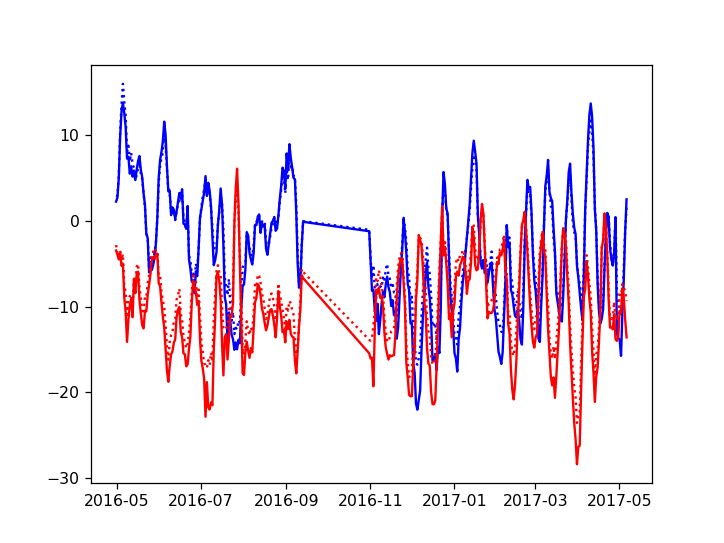

In [6]:
frq = 0
plt.figure()
plt.plot(time_amp, a0_init[frq,:],'b:')
plt.plot(time_amp, a0_opt[frq,:],'b-')
plt.plot(time_amp, a0_init[frq+nfrq,:],'r:')
plt.plot(time_amp, a0_opt[frq+nfrq,:],'r-')


<IPython.core.display.Javascript object>


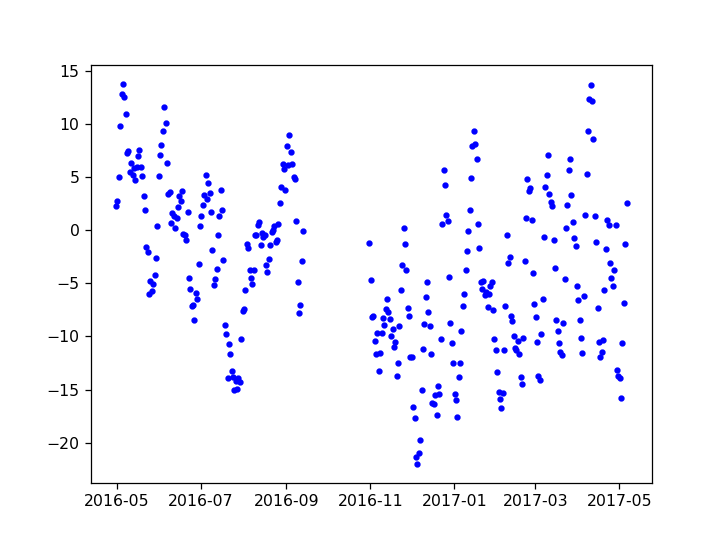

In [9]:
plt.figure()
plt.plot(time_amp, a0_opt[frq,:],'b.')

In [159]:
# Use a GP to model the data
# GP Implementation
def a0_gp_mcmc(dtime, X, T, ):
    """
    GP
    """
    # Convert the time to days

    nt = X.shape[0]
    
    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # GP
        #ℓ = BoundNormal("ℓ", mu=10000,sd=10000)
        #ℓ = pm.Gamma("ℓ", alpha=0.1,beta=0.5)
        ℓ = pm.HalfNormal("ℓ", sd=1.)
        ℓT= pm.HalfNormal("ℓT", sd=1.)


        #T = pm.Gamma("T", alpha=1.,beta=2.)
        #η = pm.HalfCauchy("η", beta=1.)
        η = pm.HalfNormal("η", sd=1.)
        η_T = pm.HalfNormal("η_T", sd=1.)


        cov = η_T**2. * pm.gp.cov.Periodic(1, T, ls=ℓT)
        cov += η**2. * pm.gp.cov.Matern52(1, ℓ)
        #cov += η**2. * pm.gp.cov.ExpQuad(1, ℓ)

        sigma = pm.HalfCauchy("sigma", beta=1.0)
        
        # Marginal GP implementation
        #gp= pm.gp.Marginal(cov_func=cov, ) # No mean
        #y_ = gp.marginal_likelihood("y", X=dtime[:,None], y=X, noise=sigma)
        
        # Use the sparse approximation
        gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")
        # initialize 20 inducing points with K-means
        Xu = pm.gp.util.kmeans_inducing_points(100, dtime[:,None])
        
        y_ = gp.marginal_likelihood("y", X=dtime[:,None],Xu=Xu, y=X, noise=sigma)
        
        mp = pm.find_MAP()
        print(mp)

        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        
        #trace=None
        trace = pm.sample(500, tune=1500, start = start, step=step, cores=1,)
        #                 )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
        
    # Calculate statistics of the inferred parameters
    def trace_sd(x):
        return pd.Series(np.std(x, 0), name='sd')
    def trace_mean(x):
        return pd.Series(np.mean(x, 0), name='mean')
    def trace_quantiles(x):
        return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
    
    #params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
    params = None
    
    # Return the trace and the parameter stats
    return trace, params, my_model, gp, mp
    

In [157]:
dtime = SecondsSince(time_amp, basetime=basetime ) / 86400.
ytime = dtime/365.25

domega =2*np.pi/(12.*3600) - 2*np.pi/(12.42*3600)
T = 2*np.pi / domega/86400/365.25 # Period for the periodic covariance kernel

frq=0
Xin = a0_opt[frq,:]
Xmu = Xin.mean()
Xstd = Xin.std()

X = (Xin-Xmu)/Xstd

trace, params, my_model, gp, mp = a0_gp_mcmc(ytime, X, T)
print(params)

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -92.679, ||grad|| = 0.86766: 100%|██████████| 37/37 [00:00<00:00, 43.58it/s]         

{'ℓ_log__': array(-4.33814942), 'ℓT_log__': array(-0.34101707), 'η_log__': array(-0.13503602), 'η_T_log__': array(-0.5743842), 'sigma_log__': array(-1.89116229), 'ℓ': array(0.01306068), 'ℓT': array(0.71104677), 'η': array(0.87368444), 'η_T': array(0.56305149), 'sigma': array(0.15089632)}
None


pm.summary(trace)

(367,)


<IPython.core.display.Javascript object>


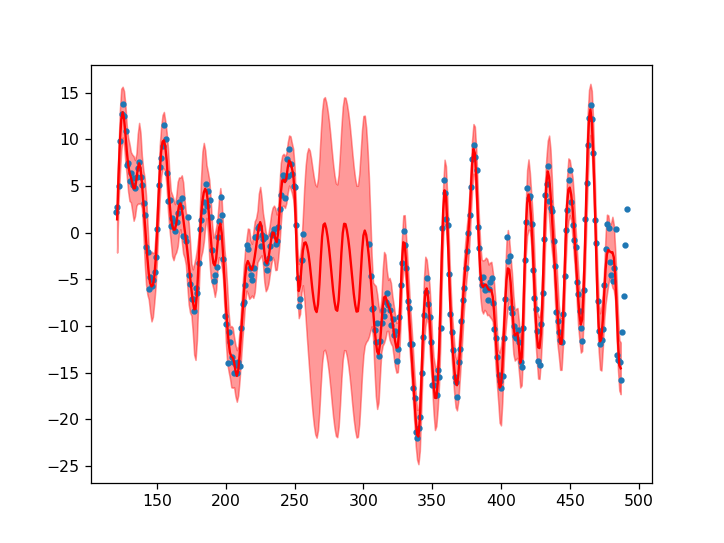

In [158]:
# yout = np.arange(120,520,1)/365.25
# ytime[0]*365.25, ytime[-1]*365.25

rhotime = pd.date_range('2016-05-01','2017-05-02',freq='D').values
yout = SecondsSince(rhotime, basetime=basetime)/86400/365.25
print(yout.shape)

# With noise included

mu, var = gp.predict(yout[:,None], point=mp,  diag=True, pred_noise=True)

Xpred = mu*Xstd + Xmu
stdpred = np.sqrt(var)*Xstd*2

plt.figure()
plt.plot(ytime*365.25, Xin,'.')
plt.plot(yout*365.25, Xpred,'r-')
plt.fill_between(yout*365.25, Xpred-stdpred, Xpred+stdpred,color='r',alpha=0.4)

In [117]:
# Make predictions with the full posterior

# add the GP conditional to the model, given the new X values
with my_model:
    f_pred = gp.conditional("f_pred", yout[:,None])

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with my_model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=500)

100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]


In [133]:
a0 = pred_samples["f_pred"]*Xstd+Xmu
a0.shape

(1000, 400)

<IPython.core.display.Javascript object>


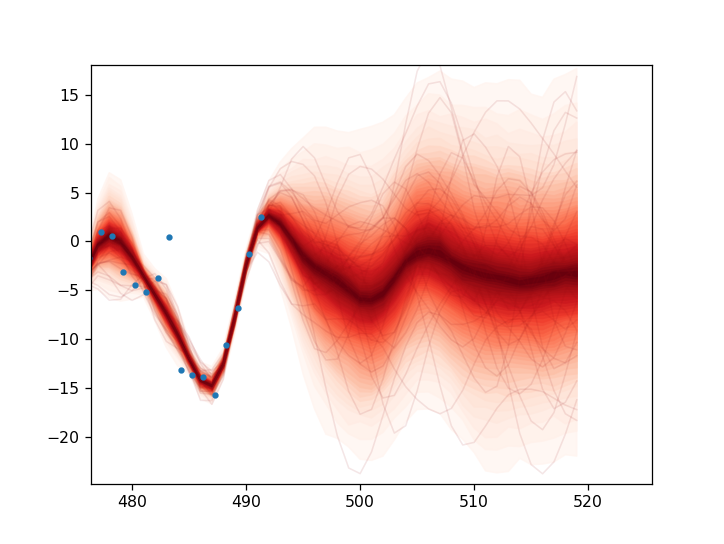

In [124]:
plt.figure()
ax=plt.gca()
pm.gp.util.plot_gp_dist(ax, pred_samples["f_pred"]*Xstd+Xmu, yout*365.25)
plt.plot(ytime*365.25, Xin,'.')
# plt.fill_between(yout*365.25, Xpred-stdpred, Xpred+stdpred,color='b',alpha=0.4)

In [140]:
def run_gp(Xin, ytime, T, yout, nsamples ):
    Xin = a0_opt[frq,:]
    Xmu = Xin.mean()
    Xstd = Xin.std()

    X = (Xin-Xmu)/Xstd
    
    trace, params, my_model, gp, mp = a0_gp_mcmc(ytime, X, T)
    
    # Make predictions with the full posterior

    # add the GP conditional to the model, given the new X values
    with my_model:
        f_pred = gp.conditional("f_pred", yout[:,None])

    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    with my_model:
        pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=nsamples)
        
    return pred_samples["f_pred"]*Xstd+Xmu


In [160]:
nsamples = 500
a0_samples = np.zeros((2*nfrq, nsamples, yout.shape[0] ))

for ii in range(2*nfrq):
    print(72*'#')
    print('Running frq {} of {}'.format(ii+1, 2*nfrq))
    a0_samples[ii,...] = run_gp(a0_opt[ii,:], ytime, T, yout, nsamples )

########################################################################
Running frq 1 of 6


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -109.56, ||grad|| = 0.2815: 100%|██████████| 35/35 [00:00<00:00, 39.74it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'ℓ_log__': array(-4.30495038), 'ℓT_log__': array(-0.06805448), 'η_log__': array(-0.13888039), 'η_T_log__': array(-0.32999261), 'sigma_log__': array(-1.75854084), 'ℓ': array(0.01350156), 'ℓT': array(0.93420958), 'η': array(0.87033212), 'η_T': array(0.71892904), 'sigma': array(0.17229609)}


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, η_T, η, ℓT, ℓ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [04:22<00:00,  7.61it/s]
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [01:57<00:00,  4.27it/s]


########################################################################
Running frq 2 of 6


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -91.785, ||grad|| = 1.5944: 100%|██████████| 38/38 [00:01<00:00, 34.62it/s]          
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'ℓ_log__': array(-4.27191214), 'ℓT_log__': array(-0.28544055), 'η_log__': array(-0.10968632), 'η_T_log__': array(-0.5511585), 'sigma_log__': array(-1.84632235), 'ℓ': array(0.01395507), 'ℓT': array(0.75168303), 'η': array(0.89611518), 'η_T': array(0.5762818), 'sigma': array(0.15781649)}


Sequential sampling (2 chains in 1 job)
NUTS: [sigma, η_T, η, ℓT, ℓ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [04:27<00:00,  7.47it/s]
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [01:47<00:00,  4.65it/s]


########################################################################
Running frq 3 of 6


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -91.171, ||grad|| = 1.151: 100%|██████████| 39/39 [00:00<00:00, 40.02it/s]           
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'ℓ_log__': array(-4.30143072), 'ℓT_log__': array(-0.43340012), 'η_log__': array(-0.15210693), 'η_T_log__': array(-0.61759406), 'sigma_log__': array(-1.84327524), 'ℓ': array(0.01354916), 'ℓT': array(0.64830104), 'η': array(0.85889644), 'η_T': array(0.53924026), 'sigma': array(0.15829811)}


Sequential sampling (2 chains in 1 job)
NUTS: [sigma, η_T, η, ℓT, ℓ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [04:26<00:00,  7.52it/s]
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [01:45<00:00,  4.74it/s]


########################################################################
Running frq 4 of 6


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -89.086, ||grad|| = 0.99408: 100%|██████████| 37/37 [00:00<00:00, 39.04it/s]        
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'ℓ_log__': array(-4.29338599), 'ℓT_log__': array(-0.2835825), 'η_log__': array(-0.12520256), 'η_T_log__': array(-0.64811112), 'sigma_log__': array(-1.84440612), 'ℓ': array(0.0136586), 'ℓT': array(0.75308099), 'η': array(0.88231816), 'η_T': array(0.52303279), 'sigma': array(0.1581192)}


Sequential sampling (2 chains in 1 job)
NUTS: [sigma, η_T, η, ℓT, ℓ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [04:21<00:00,  7.64it/s]
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [01:46<00:00,  4.68it/s]


########################################################################
Running frq 5 of 6


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -99.763, ||grad|| = 2.3011: 100%|██████████| 36/36 [00:00<00:00, 39.26it/s]          
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'ℓ_log__': array(-4.25487849), 'ℓT_log__': array(-0.31954871), 'η_log__': array(-0.09477548), 'η_T_log__': array(-0.64342838), 'sigma_log__': array(-1.79490135), 'ℓ': array(0.01419482), 'ℓT': array(0.72647682), 'η': array(0.90957713), 'η_T': array(0.52548776), 'sigma': array(0.16614384)}


Sequential sampling (2 chains in 1 job)
NUTS: [sigma, η_T, η, ℓT, ℓ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [04:22<00:00,  7.61it/s]
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [01:45<00:00,  4.75it/s]


########################################################################
Running frq 6 of 6


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -96.222, ||grad|| = 0.36448: 100%|██████████| 36/36 [00:00<00:00, 37.79it/s]     
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'ℓ_log__': array(-4.32679437), 'ℓT_log__': array(-0.13958532), 'η_log__': array(-0.10913309), 'η_T_log__': array(-0.36387033), 'sigma_log__': array(-1.86419331), 'ℓ': array(0.01320983), 'ℓT': array(0.86971882), 'η': array(0.89661108), 'η_T': array(0.69498131), 'sigma': array(0.15502121)}


Sequential sampling (2 chains in 1 job)
NUTS: [sigma, η_T, η, ℓT, ℓ]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [04:51<00:00,  6.87it/s]
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [01:46<00:00,  4.70it/s]


In [161]:
outputh5 = '../data/CRUX_a0_inverse_gp_samples_20162017.h5'
f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-all-times-samples',data=a0_samples)
g.create_dataset('time',data=yout*86400*365.25)
g.create_dataset('dtime64',data=rhotime.view(int))
g.create_dataset('frq', data=frq)
f.close()
print(outputh5)

../data/CRUX_a0_inverse_gp_samples_20162017.h5
